In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import butter, lfilter, freqz, detrend
from scipy.optimize import curve_fit
from sklearn import linear_model
from scipy import stats

In [3]:
sns.set()
sns.set_style('ticks')
sns.set_context('notebook')

In [4]:
df = pd.read_csv('/home/julia/projects/calcium_bold/calcium_data/259_05_c.csv')

In [37]:
unfiltered_data = df['signal[V]']
unfiltered_data_1 = unfiltered_data[543000:4998000]
timepoints_1 = df['timepoint[ms]'][543000:4998000]/10000
unfiltered_data_2 = unfiltered_data[6040000:]
timepoints_2 = df['timepoint[ms]'][6040000:]/10000

<IPython.core.display.Javascript object>


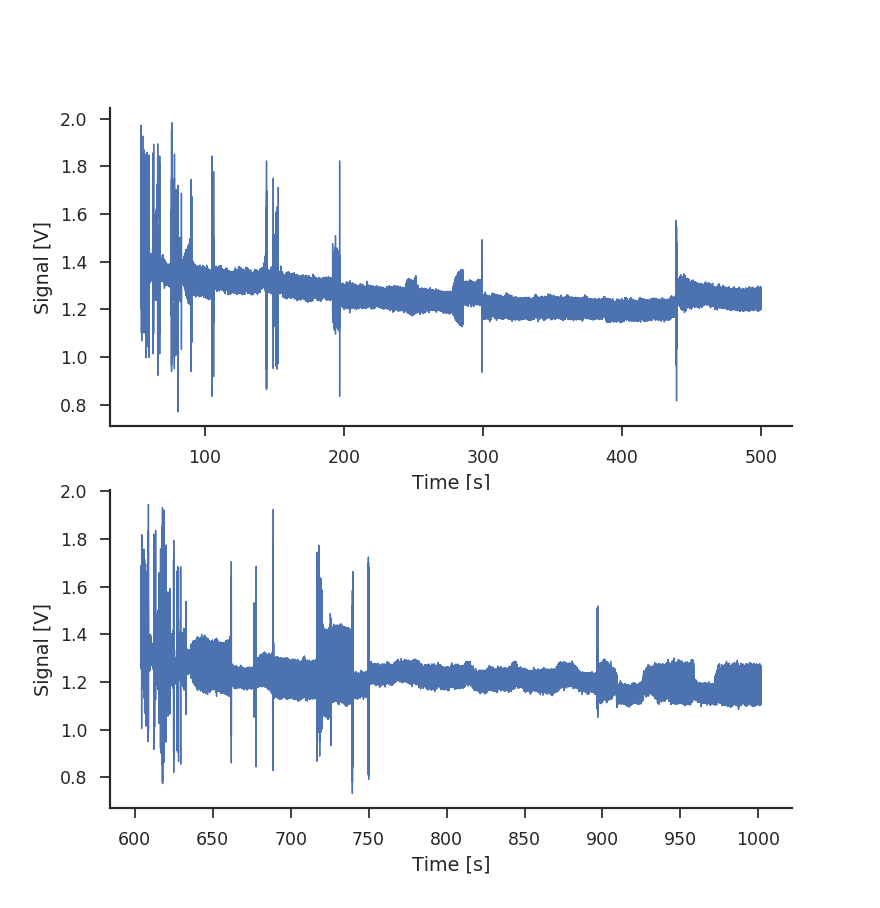

In [70]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,1,1)
#ax1.set_xticks(ticks)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Signal [V]")
ax1.plot(timepoints_1, unfiltered_data_1, linewidth=0.8)
#ax1.plot(timepoints, norm_led(led_data, unfiltered_data), color='red', linewidth=1.5)
sns.despine()


ax2 = fig.add_subplot(2,1,2)
#ax2.set_xticks(ticks)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Signal [V]")
ax2.plot(timepoints_2, unfiltered_data_2, linewidth=0.8)
#ax2.plot(timepoints, norm_led(led_data, lowpass_filtered_data), color='red', linewidth=1.5)
sns.despine()

In [71]:
fig.savefig("calcium_traces_upon_laser.png")

In [39]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [67]:
order = 6
fs = 10000.0  # sampling rate in Hz
lowpass_cutoff = 100

In [68]:
lowpass_filtered_data_1 = butter_lowpass_filter(unfiltered_data_1, lowpass_cutoff, fs, order)

<IPython.core.display.Javascript object>


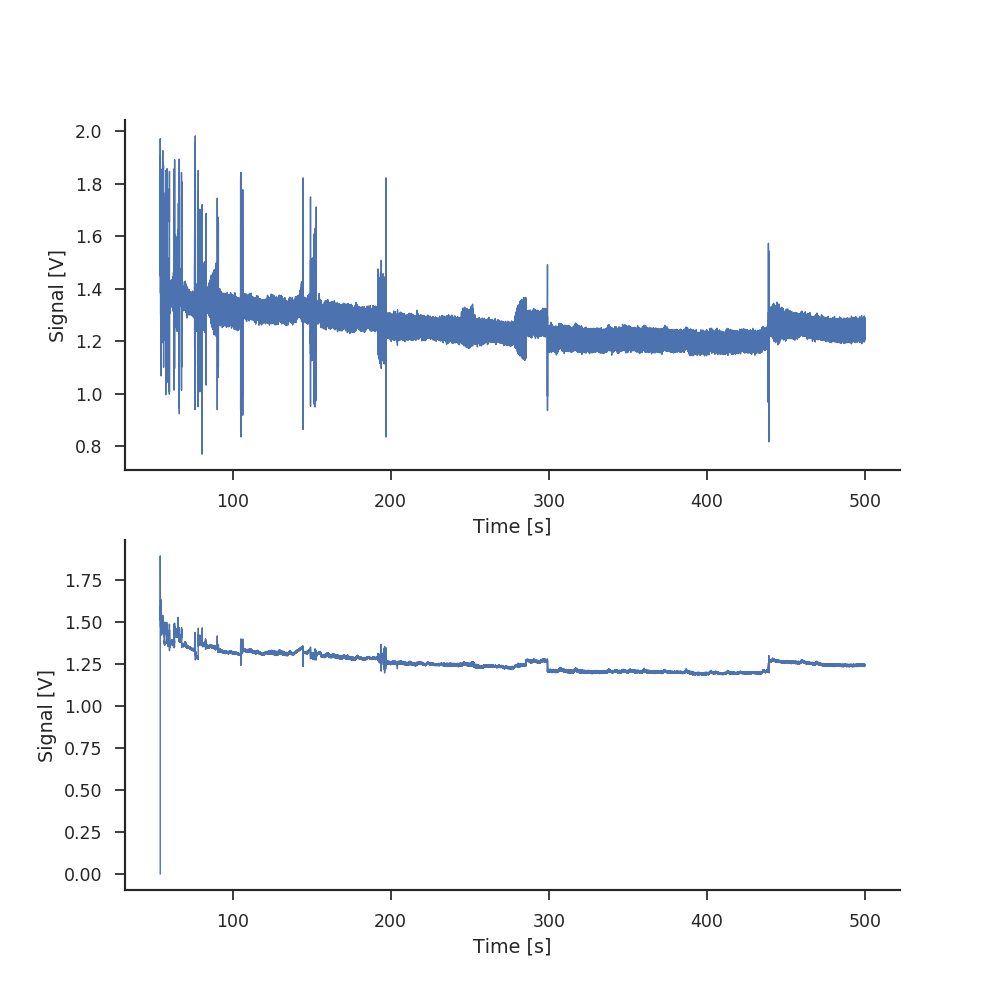

In [69]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,1,1)
#ax1.set_xticks(ticks)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Signal [V]")
ax1.plot(timepoints_1, unfiltered_data_1, linewidth=0.8)
#ax1.plot(timepoints, norm_led(led_data, unfiltered_data), color='red', linewidth=1.5)
sns.despine()

ax1 = fig.add_subplot(2,1,2)
#ax1.set_xticks(ticks)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Signal [V]")
ax1.plot(timepoints_1, lowpass_filtered_data_1, linewidth=0.8)
#ax1.plot(timepoints, norm_led(led_data, unfiltered_data), color='red', linewidth=1.5)
sns.despine()